In [1]:
import ROOT
import ostap.fixes.fixes
from ostap.core.core import cpp, Ostap
from ostap.core.core import pwd, cwd, ROOTCWD
from ostap.core.core import rootID, funcID, funID, fID, histoID, hID, dsID
from ostap.core.core import VE
from ostap.histos.histos import h1_axis, h2_axes, h3_axes
from ostap.histos.graphs import makeGraph, hToGraph, hToGraph2, hToGraph3, lw_graph
import ostap.trees.trees
import ostap.trees.cuts
import ostap.histos.param
import ostap.histos.compare
import ostap.io.root_file
import ostap.math.models
import ostap.fitting.roofit 
import ostap.fitting.models as Models

Welcome to JupyROOT 6.20/06


In [60]:
canv = ROOT.TCanvas("canv","canv",900,450)
rfile = ROOT.TFile("rad/new.root","READ")
ds = rfile["tree"]

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


In [61]:
from math import sqrt
my_events = []
for ev in ds:
    lCSC  = sqrt( ev.xCSC**2 + ev.yCSC**2 )
    zTPC  = ev.zpos+2.19+ROOT.gRandom.Gaus(0,0.2576)
    Treco = ev.Tp+ROOT.gRandom.Gaus(0,0.05)
    evt = {"T":Treco, "l":lCSC, "z":zTPC, "Atr":ev.THETAe, "Ttr":ev.Tp, "Ztr":ev.zpos}
    my_events.append( evt )
print("EVENTS SELECTED: " + str(len(my_events)))

EVENTS SELECTED: 250000


h1: mean=( 136.897 +- 0.0718767 )	 rms=( 7.96925 +- 0.320411 )	0.05860215293325179
h2: mean=( 136.897 +- 0.0718767 )	 rms=( 7.96925 +- 0.320411 )	( 0.000525043 +- 2.7567e-07 )


Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).


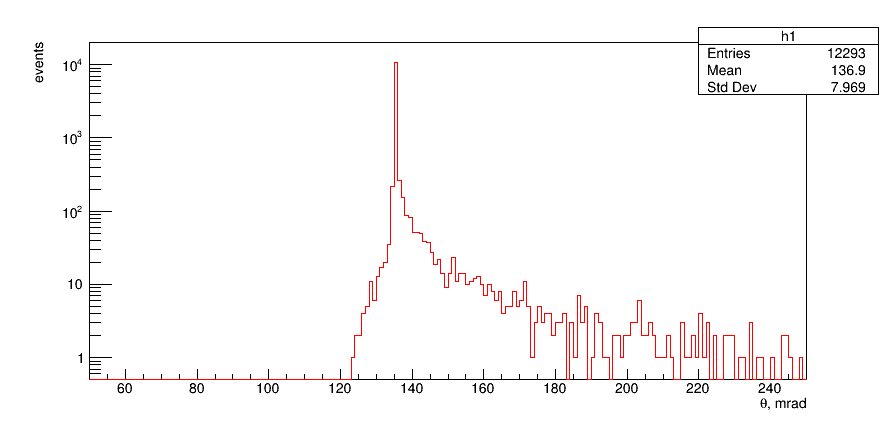

In [62]:
h1 = ROOT.TH1F("h1",";#theta, mrad;events",200,50,250)
h2 = ROOT.TH1F("h2",";#theta, mrad;events",200,50,250)
h2.SetLineColor(2)
for ev in my_events:
    if ev["Ttr"]>4.995 and ev["Ttr"]<5.005:
        h1.Fill(1000.*ev["Atr"])
    if ev["Ttr"]>4.995 and ev["Ttr"]<5.005:
        h2.Fill(1000.*ev["Atr"])
h1.Draw()
h2.Draw("same")
ROOT.gPad.SetLogy()
canv.Draw()
print("h1: mean=" + str(h1.mean()) + "\t rms=" + str(h1.rms()) + "\t" + str(h1.rms().value()/sqrt(18493.)))
print("h2: mean=" + str(h2.mean()) + "\t rms=" + str(h2.rms()) + "\t" + str(h2.mean().prec()))

33598 events
TRUE mean( 136.907 +- 0.0594648 ) mrad.
REC. mean( 136.528 +- 0.522009 ) mrad.	( 0.00382345 +- 1.46188e-05 )

****************************************
Minimizer is Linear / Migrad
Chi2                      =      38.2302
NDf                       =           35
p0                        =      1.10616   +/-   0.344002    
p1                        =     0.137383   +/-   0.000531862 


Warning in <TROOT::Append>: Replacing existing TH1: hR_Ztr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hR (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hA (Potential memory leak).


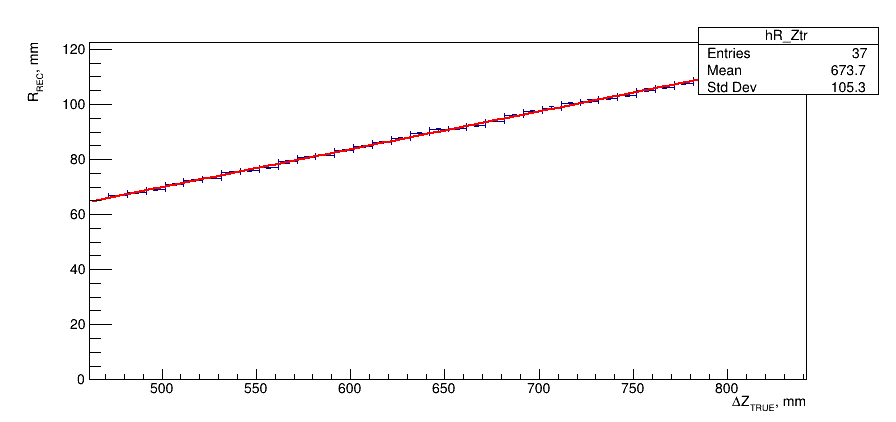

In [63]:
hR_Ztr = ROOT.TH1F("hR_Ztr",";#DeltaZ_{TRUE}, mm;R_{REC}, mm",38,851.6-390.0,851.6-10.0)
hR     = ROOT.TH1F("hR",";R_{REC},mm;events",30000,0,300)
hA     = ROOT.TH1F("hA",";#theta, mrad;events",200,100,300)
Nevt = 0
dT = 0.015
for bin in range(1,38):
    hR.Reset()
    for ev in my_events:
        if ev["T"]>5.-dT and ev["T"]<5.+dT:
            if ev["z"]>10.*bin and ev["z"]<10.*(bin+1):
                hR.Fill(ev["l"])
                hA.Fill(1000.*ev["Atr"])
                Nevt+=1
    hR_Ztr[39-bin]=hR.mean()
    #print("Bin " + str(bin) + " is done" )
hR_Ztr.Draw("e1")
f_pol1 = ROOT.TF1("f_pol1","pol1(0)",851.6-390.0,851.6-10.0)
hR_Ztr.Fit(f_pol1)
ROOT.gPad.SetLogy(False)
canv.Draw()
tgA = VE(f_pol1.GetParameter(1),f_pol1.GetParError(1)**2)
#print(tgA)
import ostap.math.math_ve as math_ve
th_true = hA.mean()
th_reco = 1000.*math_ve.atan(tgA)
print(str(Nevt)+" events")
print("TRUE mean" + str(th_true) + " mrad.") 
print("REC. mean" + str(th_reco) + " mrad.\t" + str(th_reco.prec())) 

12373 events
TRUE mean( 137.322 +- 0.0990873 ) mrad.	( 0.000721566 +- 5.20658e-07 )
REC. mean( 136.675 +- 0.674253 ) mrad.	( 0.00493327 +- 2.43372e-05 )

****************************************
Minimizer is Linear / Migrad
Chi2                      =      41.5234
NDf                       =           36
p0                        =     0.461578   +/-   0.438305    
p1                        =     0.137532   +/-   0.000687007 


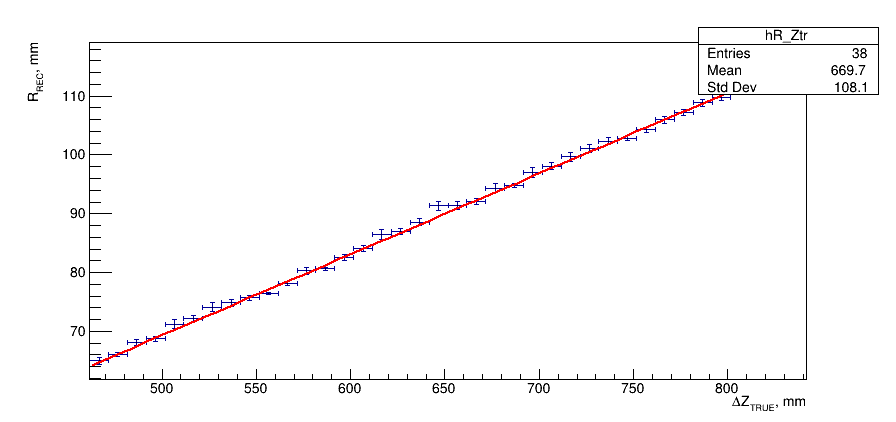

In [64]:
hR_Ztr.Reset()
hR.Reset()
hA.Reset()
Nevt = 0
dT = 0.005
for bin in range(1,39):
    hR.Reset()
    for ev in my_events:
        if ev["Ttr"]>5.-dT and ev["Ttr"]<5.+dT:
            if ev["Ztr"]>10.*bin and ev["Ztr"]<10.*(bin+1):
                hR.Fill(ev["l"])
                hA.Fill(1000.*ev["Atr"])
                Nevt+=1
    hR_Ztr[39-bin]=hR.mean()
    #print("Bin " + str(bin) + " is done" )
hR_Ztr.Draw("e1")
f_pol1 = ROOT.TF1("f_pol1","pol1(0)",851.6-390.0,851.6-10.0)
hR_Ztr.Fit(f_pol1)
ROOT.gPad.SetLogy(False)
canv.Draw()
tgA = VE(f_pol1.GetParameter(1),f_pol1.GetParError(1)**2)
#print(tgA)
import ostap.math.math_ve as math_ve
th_true = hA.mean()
th_reco = 1000.*math_ve.atan(tgA)
print(str(Nevt)+" events")
print("TRUE mean" + str(th_true) + " mrad.\t" + str(th_true.prec())) 
print("REC. mean" + str(th_reco) + " mrad.\t" + str(th_reco.prec()))

In [40]:
ROOT.TMath.Prob(69.5,36)

0.0006697586872903862